In [1]:
from ALLCools.mcds import MCDS
from ALLCools.plot import *
from ALLCools.integration import confusion_matrix_clustering

from wmb import cemba, aibs, broad, brain

import pandas as pd
import numpy as np
import anndata
import matplotlib.pyplot as plt
import seaborn as sns

CEMBA_SNM3C_3C_CHROM100K_RAW_ZARR_PATH do not exist: /gale/netapp/cemba3c/BICCN/CEMBA_3C/mcds/CEMBA.snm3C.chrom100k_raw.zarr
CEMBA_SNM3C_3C_COMPARTMENT_ZARR_PATH do not exist: /gale/netapp/cemba3c/BICCN/CEMBA_3C/mcds/CEMBA.snm3C.3C.mcds/chrom100k
CEMBA_SNM3C_3C_DOMAIN_INSULATION_ZARR_PATH do not exist: /gale/netapp/cemba3c/BICCN/CEMBA_3C/mcds/CEMBA.snm3C.3C.mcds/chrom25k


In [2]:
category_key = 'L2'
plot_key = 'L2'
dataset = 'AIBS_SMART'

In [3]:
mc_annot = cemba.get_mc_annot()

if dataset == 'AIBS_SMART':
    rna_annot = aibs.get_smart_annot()
elif dataset == 'AIBS_TENX':
    rna_annot = aibs.get_tenx_annot()
else:
    rna_annot = broad.get_tenx_annot()

In [4]:
adata_merge = anndata.read_h5ad('final_with_coords.h5ad')

In [5]:
adata_merge

AnnData object with n_obs × n_vars = 10000 × 3318
    obs: 'count', 'read_count', 'n_counts', 'Modality', 'DissectionRegion', 'L1_annot', 'L2', 'L1_annot_transfer', 'L2_transfer', 'DissectionRegion_transfer', 'leiden'
    var: 'chrom', 'end-RNA', 'start-RNA', 'mean-RNA', 'std-RNA', 'cov_mean-mC', 'end-mC', 'start-mC'
    uns: 'leiden', 'neighbors', 'umap'
    obsm: 'X_harmony', 'X_pca_integrate', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

In [6]:
rna_adata = adata_merge[adata_merge.obs['Modality'] == 'RNA'].copy()
mc_adata = adata_merge[adata_merge.obs['Modality'] == 'mC'].copy()

In [7]:
rna_meta = adata_merge.obs[adata_merge.obs['Modality'] == 'RNA'].copy()
mc_meta = adata_merge.obs[adata_merge.obs['Modality'] == 'mC'].copy()

## Determine integration group
In RNA L2 resolution, assign RNA L2 to its most probable mC clusters where the sum of probability > 0.95

In [8]:
confusion_matrix = pd.read_hdf(f'{category_key}.overlap_score.hdf')

In [9]:
row_group, col_group, confusion_matrix, diag_score = confusion_matrix_clustering(
    confusion_matrix, min_value=0, max_value=0.9)

print(f'Diagonal Score: {diag_score:.2f}')

<AxesSubplot:>

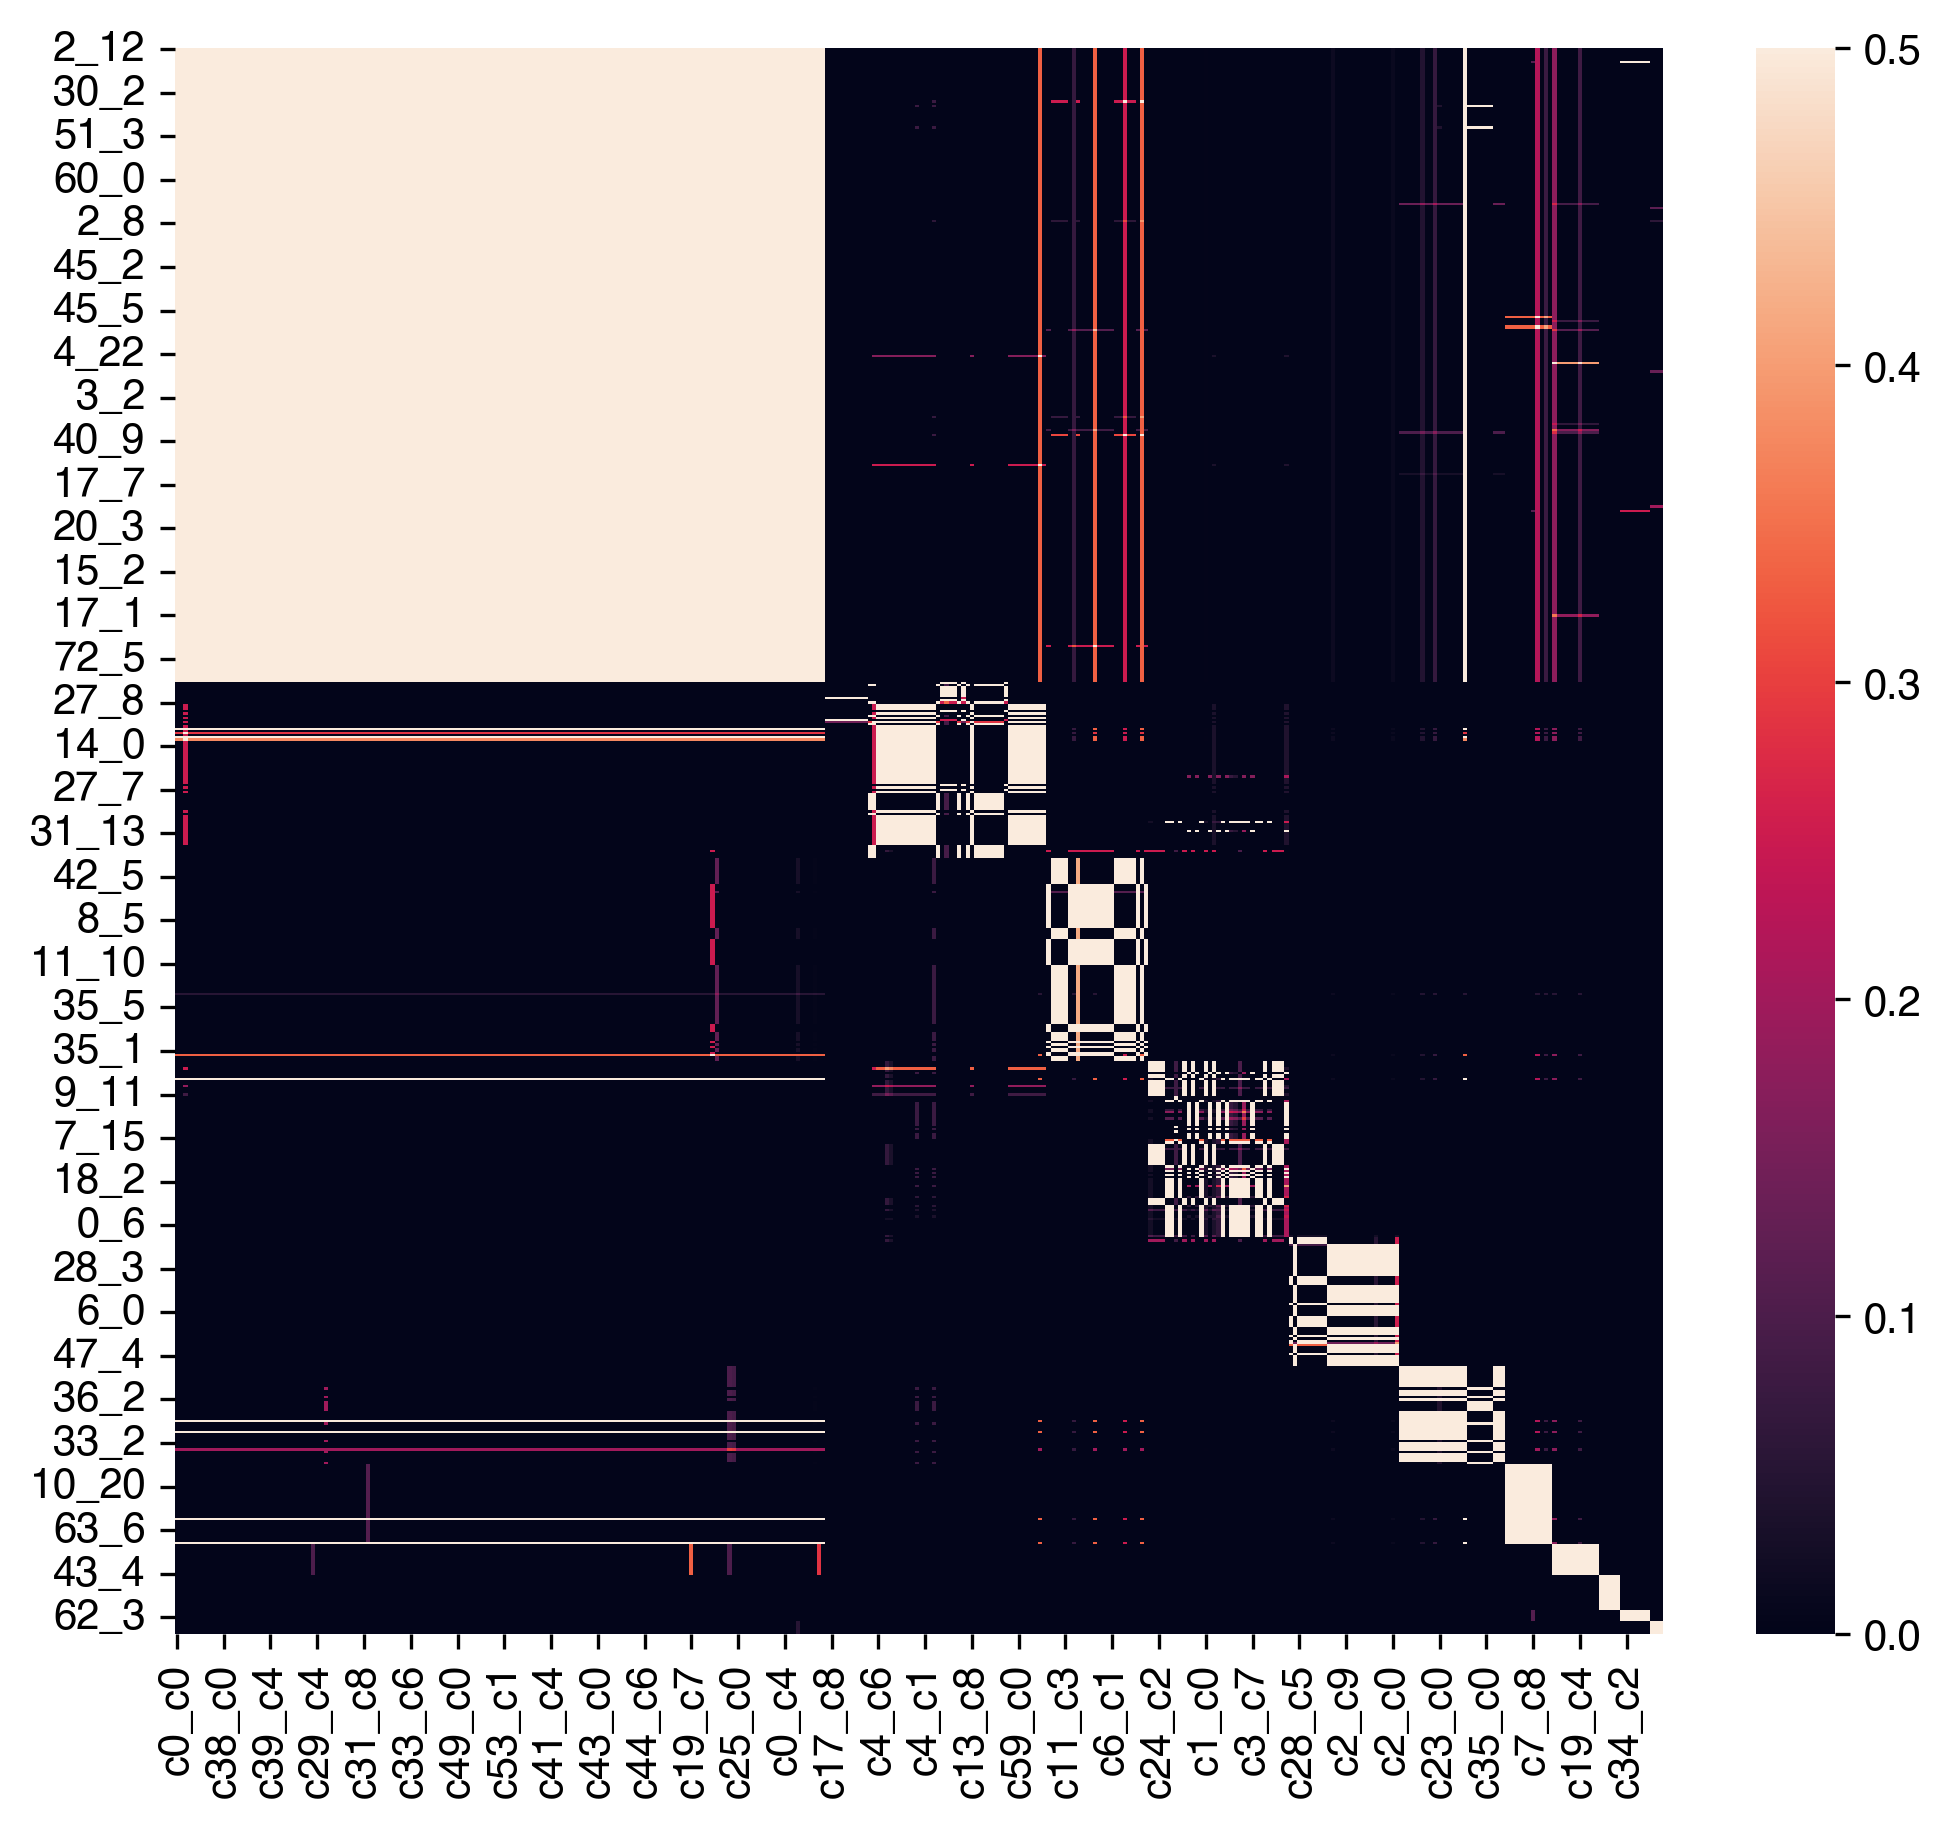

In [10]:
fig, ax = plt.subplots(figsize=(8, 7), dpi=300)
sns.heatmap(confusion_matrix, ax=ax, vmin=0, vmax=0.5)

In [11]:
rna_adata.obs['InteGroup'] = rna_adata.obs[category_key].map(row_group)
rna_adata.obs['InteGroup'].value_counts()

0     1780
3      947
2      879
1      418
4      387
5      238
6      223
8       71
7       40
9       11
10       6
Name: InteGroup, dtype: int64

In [12]:
mc_adata.obs['InteGroup'] = mc_adata.obs[category_key].map(col_group)
mc_adata.obs['InteGroup'].value_counts()

0     1514
3     1195
1      692
4      486
5      318
2      312
6      235
7       82
10      71
8       57
9       38
Name: InteGroup, dtype: int64

## Manual Adjust

### Merge Integration Group

In [13]:
inte_group_map = {
    # if need to merge integration group, add k:v here
    # 1: 0,
}

rna_adata.obs['InteGroup'] = rna_adata.obs['InteGroup'].map(
    lambda i: inte_group_map[i] if i in inte_group_map else i)
mc_adata.obs['InteGroup'] = mc_adata.obs['InteGroup'].map(
    lambda i: inte_group_map[i] if i in inte_group_map else i)

### Plot integration groups

In [14]:
from ALLCools.plot.color import level_one_palette

inte_group_palette = level_one_palette(
    pd.concat([rna_adata.obs['InteGroup'], mc_adata.obs['InteGroup']]), 
    palette='tab20'
)

[Text(0.5, 1.0, 'RNA Inte. Group')]

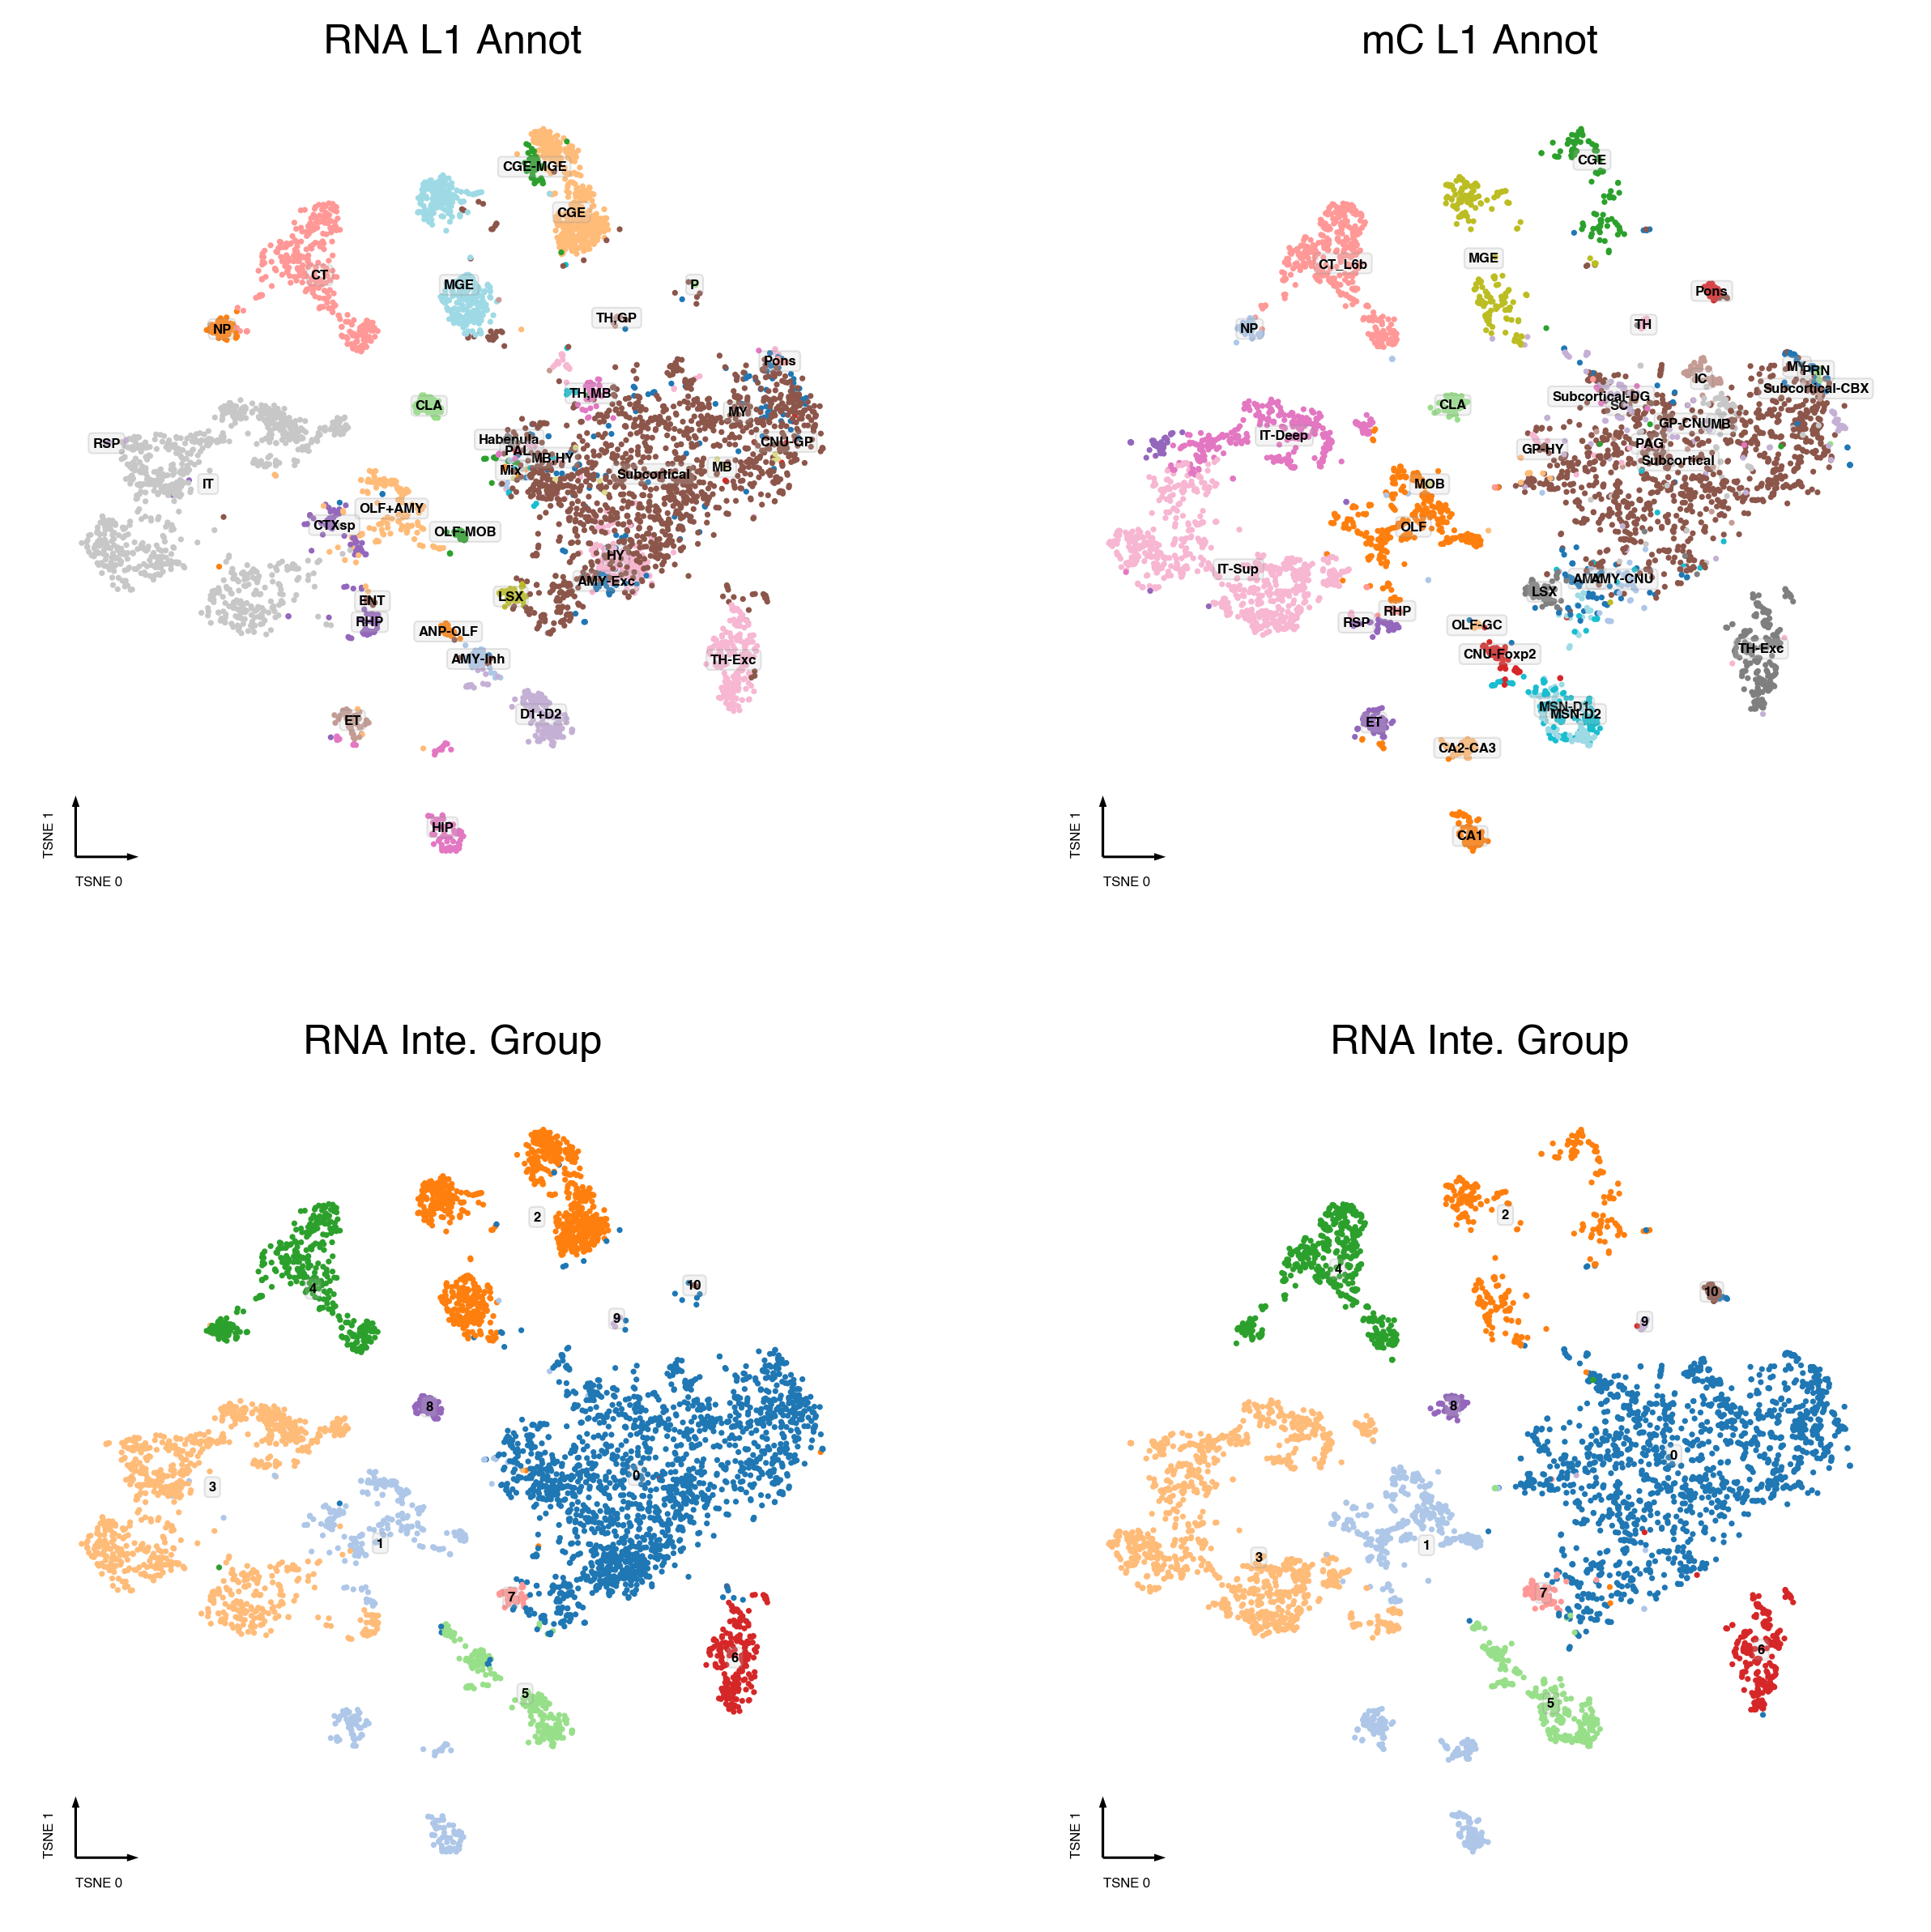

In [15]:
fig, axes = plt.subplots(figsize=(10, 10), ncols=2, nrows=2, dpi=300)

ax = axes[0, 0]
categorical_scatter(ax=ax,
                    data=rna_adata,
                    coord_base='tsne',
                    palette='tab20',
                    hue=plot_key,
                    text_anno=plot_key,
                    max_points=None)
ax.set(title=f'RNA {plot_key}')

ax = axes[1, 0]
categorical_scatter(ax=ax,
                    data=rna_adata,
                    coord_base='tsne',
                    hue='InteGroup',
                    text_anno='InteGroup',
                    palette=inte_group_palette,
                    max_points=None)
ax.set(title='RNA Inte. Group')

ax = axes[0, 1]
categorical_scatter(ax=ax,
                    data=mc_adata,
                    coord_base='tsne',
                    palette='tab20',
                    hue=plot_key,
                    text_anno=plot_key,
                    max_points=None)
ax.set(title=f'mC {plot_key}')
ax = axes[1, 1]
categorical_scatter(ax=ax,
                    data=mc_adata,
                    coord_base='tsne',
                    hue='InteGroup',
                    text_anno='InteGroup',
                    palette=inte_group_palette,
                    max_points=None)
ax.set(title='mC Inte. Group')

## Save Integration Group

In [16]:
# map integration group to all cells based on intra-dataset clustering
counts = mc_adata.obs.groupby(category_key)['InteGroup'].value_counts()
mc_cluster_to_inte_group = {
    mc: inte_group
    for mc, inte_group in counts[counts > 0].index
}
mc_cell_inte_group = mc_annot[category_key].to_pandas().map(
    mc_cluster_to_inte_group).dropna().astype(int)

mc_cell_inte_group.to_csv('mc_integration_group.csv.gz')
mc_cell_inte_group.value_counts()

0     77849
3     61221
1     34832
4     24706
2     18161
5     17284
6     10797
7      3951
10     3358
8      3165
9      1971
dtype: int64

In [17]:
counts = rna_adata.obs.groupby(category_key)['InteGroup'].value_counts()
rna_cluster_to_inte_group = {
    rna: inte_group
    for rna, inte_group in counts[counts > 0].index
}
rna_cell_inte_group = rna_annot[category_key].to_pandas().map(
    rna_cluster_to_inte_group).dropna().astype(int)

rna_cell_inte_group.to_csv('rna_integration_group.csv.gz')
rna_cell_inte_group.value_counts()

0     53239
3     29570
2     27915
4     12523
1     12333
5      7775
6      6218
8      2293
7      1231
9       280
10      218
dtype: int64

## Plot Individual Group

1. is there mC cluster do not match to any RNA cluster?
2. different separatetion between mC / RNA

In [18]:
def plot_single_group(group):
    rna_hue = rna_adata.obs['InteGroup'] == group
    mc_hue = mc_adata.obs['InteGroup'] == group

    fig, axes = plt.subplots(figsize=(10, 10), ncols=2, nrows=2, dpi=300)

    ax = axes[0, 0]
    categorical_scatter(ax=ax,
                        data=rna_adata,
                        coord_base='tsne',
                        hue='L1_annot',
                        text_anno='L1_annot',
                        max_points=None)
    ax.set(title='RNA L1 Annot')

    ax = axes[1, 0]
    categorical_scatter(ax=ax,
                        data=rna_adata,
                        coord_base='tsne',
                        hue=rna_hue,
                        palette={
                            True: 'red',
                            False: 'lightgrey'
                        },
                        text_anno='InteGroup',
                        max_points=None)
    ax.set(title='RNA Inte. Group')

    ax = axes[0, 1]
    categorical_scatter(ax=ax,
                        data=mc_adata,
                        coord_base='tsne',
                        hue='L1_annot',
                        text_anno='L1_annot',
                        max_points=None)
    ax.set(title='mC L1 Annot')

    ax = axes[1, 1]
    categorical_scatter(ax=ax,
                        data=mc_adata,
                        coord_base='tsne',
                        hue=mc_hue,
                        palette={
                            True: 'red',
                            False: 'lightgrey'
                        },
                        text_anno='InteGroup',
                        max_points=None)
    ax.set(title='RNA Inte. Group')
    return fig

In [19]:
# import matplotlib.backends.backend_pdf
# 
# with matplotlib.backends.backend_pdf.PdfPages("integration_groups.pdf") as pdf:
#     for group in rna_adata.obs['InteGroup'].unique():
#         fig = plot_single_group(group)
#         pdf.savefig(fig)